In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
import re
import os
import time
import datetime
import gc
from random import random
import sklearn
import string
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import os

In [3]:
def get_train(filepath): # a simple function to divide sentences and the similarity 
    print("Loading training data from "+filepath)
    x1=[]
    x2=[]
    y=[]
    # positive samples from file
    for line in open(filepath):
        l=line.strip().split("\t")
        if len(l)<2:
            continue
        if random() > 0.5:
            x1.append(l[0].lower())
            x2.append(l[1].lower())
        else:
            x1.append(l[1].lower())
            x2.append(l[0].lower())
        y.append(int(l[2]))
    return np.asarray(x1),np.asarray(x2),np.asarray(y)

In [4]:
def dumpValidation(x1_text,x2_text,y,shuffled_index,val_idx): #leaving out some sentences to test later 
    print("dumping validation ")
    x1_shuffled=x1_text[shuffled_index]
    x2_shuffled=x2_text[shuffled_index]
    y_shuffled=y[shuffled_index]
    x1_val=x1_shuffled[val_idx:]
    x2_val=x2_shuffled[val_idx:]
    y_val=y_shuffled[val_idx:]
    del x1_shuffled
    del y_shuffled
    with open('validation.txt','w') as f:
        for text1,text2,label in zip(x1_val,x2_val,y_val):
            f.write(str(label)+"\t"+text1+"\t"+text2+"\n")
        f.close()
    del x1_val
    del y_val

In [5]:
def getDataSets(training_paths, percent_val): #pour organiser mes donneesss

    x1_text, x2_text, y= get_train(training_paths) # Splitting parts of each line in our data
    # Build vocabulary
    print("Building vocabulary")
        
    
    train_set=[]
    val_set=[]
        

    
    # Randomly shuffle data
    np.random.seed(42)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x1_shuffled = x1_text[shuffle_indices]
    x2_shuffled = x2_text[shuffle_indices]
    y_shuffled = y[shuffle_indices]
    val_idx = -1*len(y_shuffled)*percent_val//100

    
    
    # Saving for validation thingies
    dumpValidation(x1_text,x2_text,y,shuffle_indices,val_idx)
    
    
    # Getting random samples for each column
    x1_train, x1_val = x1_shuffled[:val_idx], x1_shuffled[val_idx:]
    x2_train, x2_val = x2_shuffled[:val_idx], x2_shuffled[val_idx:]
    y_train, y_val = y_shuffled[:val_idx], y_shuffled[val_idx:]
    print("Train/val split for {}: {:d}/{:d}".format(training_paths, len(y_train), len(y_val)))
    
    train_set=(x1_train,x2_train,y_train)
    val_set=(x1_val,x2_val,y_val)
    
    gc.collect()
    return train_set,val_set

In [6]:
def get_test(filepath): #Getting our test data
    print("Loading testing/labelled data from "+filepath +" and preparing it for prediction ")
    x1=[]
    x2=[]
    y=[]
    # positive samples from file
    for line in open(filepath):
        l=line.strip().split("\t")
        if len(l)<3: # Get only relevantly long sentences
            continue
        x1.append(l[1].lower())
        x2.append(l[2].lower())
        y.append(int(l[0])) 
        
    
    return x1,x2,y

In [7]:
training_files= "train_snli.txt"     #for sentence semantic similarity 


In [8]:
train_set, val_set= getDataSets(training_files, 10)


Loading training data from train_snli.txt
Building vocabulary
dumping validation 
Train/val split for train_snli.txt: 330635/36738


In [9]:
train_x1, train_x2, train_y = train_set
val_x1, val_x2, val_y = val_set
test_x1, test_x2, test_y = get_test('validation.txt')

Loading testing/labelled data from validation.txt and preparing it for prediction 


In [10]:
def preprocess(sentences):
    # Convert to lowercase
    sentences = [s.lower() for s in sentences]
    # Remove punctuation
    sentences = [s.translate(str.maketrans('', '', string.punctuation)) for s in sentences]
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    sentences = [' '.join([word for word in s.split() if word not in stop_words]) for s in sentences]
    return sentences

In [11]:
# Preprocess train and validation data
train_x1 = preprocess(train_x1)
train_x2 = preprocess(train_x2)
val_x1 = preprocess(val_x1)
val_x2 = preprocess(val_x2)

In [13]:
# Load the pre-trained BERT model and tokenizer
bert_model = TFBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

c:\Users\Rania\anaconda3\envs\mybase\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rania\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and 

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFBertModel: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'distilbert', 'activation_13']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


from transformers import TFRobertaModel, RobertaTokenizer

roberta_model = TFRobertaModel.from_pretrained('roberta-base')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

from transformers import TFXLNetModel, XLNetTokenizer

xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

from transformers import TFDistilBertModel, DistilBertTokenizer

distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [14]:
# Convert the training and validation datasets to TensorFlow Datasets
train_x1_enc = tokenizer(train_x1, return_tensors='tf', padding=True, truncation=True)
train_x2_enc = tokenizer(train_x2, return_tensors='tf', padding=True, truncation=True)
train_y_enc = tf.convert_to_tensor(train_y)
val_x1_enc = tokenizer(val_x1, return_tensors='tf', padding=True, truncation=True)
val_x2_enc = tokenizer(val_x2, return_tensors='tf', padding=True, truncation=True)
val_y_enc = tf.convert_to_tensor(val_y)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [15]:
# Create TensorFlow Datasets for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_x1_enc['input_ids'], train_x2_enc['input_ids']), train_y_enc)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_x1_enc['input_ids'], val_x2_enc['input_ids']), val_y_enc)).batch(16)

In [25]:
class CosSimModel(tf.keras.Model):
    def __init__(self, bert_model):
        super(CosSimModel, self).__init__()
        self.bert_model = bert_model
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.fc = tf.keras.layers.Dense(32, activation='relu')
    
    def call(self, inputs):
        x1, x2 = inputs
        x1_encodings = self.bert_model(x1)['pooler_output']
        x2_encodings = self.bert_model(x2)['pooler_output']
        cos_sim = tf.keras.losses.cosine_similarity(x1_encodings, x2_encodings)
        sim_score = tf.math.sigmoid(cos_sim)
        return sim_score

class CosSimModel(tf.keras.Model):
    def __init__(self, bert_model):
        super(CosSimModel, self).__init__()
        self.bert_model = bert_model
        self.dropout = tf.keras.layers.Dropout(0.1)
        self.fc = tf.keras.layers.Dense(768, activation='relu')
    
    def call(self, inputs):
        x1, x2 = inputs
        x1_encodings = self.bert_model(x1)['pooler_output']
        x2_encodings = self.bert_model(x2)['pooler_output']
        x1_encodings = self.dropout(x1_encodings)
        x2_encodings = self.dropout(x2_encodings)
        x1_encodings = self.fc(x1_encodings)
        x2_encodings = self.fc(x2_encodings)
        cos_sim = tf.keras.losses.cosine_similarity(x1_encodings, x2_encodings)
        sim_score = tf.math.sigmoid(cos_sim)
        return sim_score

In [26]:
# Instantiate the custom Keras model
model = CosSimModel(bert_model)

In [27]:
# Def a loss func
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)
metric = tf.keras.metrics.MeanAbsoluteError()

In [28]:
# Compile the model with a binary cross-entropy loss function and an Adam optimizer
model.compile(loss=loss_fn, optimizer=opt, metrics=[metric])

In [29]:
# Define callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.1
    else:
        return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [30]:
# Fine-tune the model on the training set and evaluate on the validation set
with tf.device('/gpu:0'):
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=500, callbacks=[early_stopping_callback, lr_callback], shuffle=True)

Epoch 1/500
20665/20665 [==============================] - 5066s 244ms/step - loss: 0.2517 - mean_absolute_error: 0.5000 - val_loss: 0.3040 - val_mean_absolute_error: 0.5006
Epoch 2/500
20665/20665 [==============================] - 4308s 208ms/step - loss: 0.2505 - mean_absolute_error: 0.5000 - val_loss: 0.3040 - val_mean_absolute_error: 0.5006
Epoch 3/500
20665/20665 [==============================] - 4417s 214ms/step - loss: 0.2505 - mean_absolute_error: 0.5000 - val_loss: 0.3040 - val_mean_absolute_error: 0.5006
Epoch 4/500
12069/20665 [================>.............] - ETA: 28:17 - loss: 0.2505 - mean_absolute_error: 0.5000

KeyboardInterrupt: 

In [ ]:
# Save the fine-tuned model
model.save_weights('fine-tuned-model.h5')

In [ ]:
# Test the fine-tuned model on some example text pairs
test_x1 = ['This is a green apple', 'This is a green apple']
test_x2 = ['This is a red fruit', 'This is a green vegetable']
test_x1_enc = tokenizer(test_x1, return_tensors='tf', padding=True, truncation=True)
test_x2_enc = tokenizer(test_x2, return_tensors='tf', padding=True, truncation=True)
test_cos_sim_values = model.predict((test_x1_enc['input_ids'], test_x2_enc['input_ids']))
print(f'Test cosine similarity values: {test_cos_sim_values}')

Test cosine similarity values: [0.26894143 0.26894143]


In [ ]:
# Plot the training and validation loss and accuracy
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('plots/loss-distil.png')
plt.show()

NameError: name 'history' is not defined

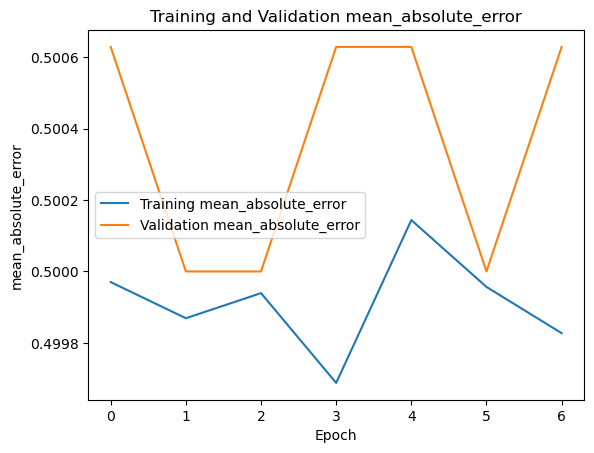

In [ ]:
plt.plot(history.history['mean_absolute_error'], label='Training mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation mean_absolute_error')
plt.legend()
plt.title('Training and Validation mean_absolute_error')
plt.xlabel('Epoch')
plt.ylabel('mean_absolute_error')
plt.savefig('plots/accuracy-distil.png')
plt.show()

In [ ]:
# Compute evaluation metrics on validation set predictions and labels 
val_preds = [int(sim > 0.5) for sim in model.predict(val_dataset)]

In [ ]:
# Metriques
val_acc = accuracy_score(val_y_enc.numpy(), val_preds)
val_prec = precision_score(val_y_enc.numpy(), val_preds)
val_rec = recall_score(val_y_enc.numpy(), val_preds)
val_f1 = f1_score(val_y_enc.numpy(), val_preds)

print(f'Validation accuracy: {val_acc:.4f}')
print(f'Validation precision: {val_prec:.4f}')
print(f'Validation recall: {val_rec:.4f}')
print(f'Validation F1-score: {val_f1:.4f}')


Validation accuracy: 0.4986
Validation precision: 0.0000
Validation recall: 0.0000
Validation F1-score: 0.0000


c:\Users\Rania\anaconda3\envs\mybase\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Rania\AppData\Local\Temp\ipykernel_77516\3490382375.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + ['Negative', 'Positive'])
C:\Users\Rania\AppData\Local\Temp\ipykernel_77516\3490382375.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + ['Negative', 'Positive'])


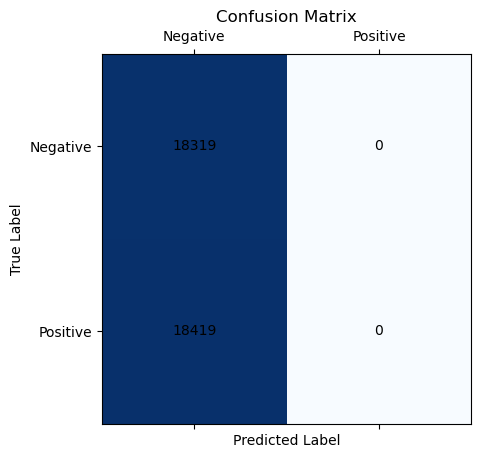

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(val_y_enc.numpy(), val_preds)
fig, ax = plt.subplots()
ax.matshow(cm, cmap=plt.cm.Blues)
ax.set_xticklabels([''] + ['Negative', 'Positive'])
ax.set_yticklabels([''] + ['Negative', 'Positive'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('plots/confusion_matrix_distil.png')
plt.show()